<a href="https://colab.research.google.com/github/oliverfyh/Video-based-Action-Recognition/blob/main/Video_based_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!git clone https://github.com/oliverfyh/Video-based-Action-Recognition.git

fatal: destination path 'Video-based-Action-Recognition' already exists and is not an empty directory.


In [61]:
!pip install torch==1.6.0 torchvision==0.7.0
!pip install --upgrade gluoncv
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip install decord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import numpy as np
import decord
import torch

from gluoncv.torch.utils.model_utils import download
from gluoncv.torch.data.transforms.videotransforms import video_transforms, volume_transforms
from gluoncv.torch.engine.config import get_cfg_defaults
from gluoncv.torch.model_zoo import get_model



from tensorflow_docs.vis import embed
# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

Testing on UCF101 dataset

In [66]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [67]:
#@title Get the kinetics-400 labels
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [91]:
for i,label in enumerate(labels):
  print(i,label)

0 abseiling
1 air drumming
2 answering questions
3 applauding
4 applying cream
5 archery
6 arm wrestling
7 arranging flowers
8 assembling computer
9 auctioning
10 baby waking up
11 baking cookies
12 balloon blowing
13 bandaging
14 barbequing
15 bartending
16 beatboxing
17 bee keeping
18 belly dancing
19 bench pressing
20 bending back
21 bending metal
22 biking through snow
23 blasting sand
24 blowing glass
25 blowing leaves
26 blowing nose
27 blowing out candles
28 bobsledding
29 bookbinding
30 bouncing on trampoline
31 bowling
32 braiding hair
33 breading or breadcrumbing
34 breakdancing
35 brush painting
36 brushing hair
37 brushing teeth
38 building cabinet
39 building shed
40 bungee jumping
41 busking
42 canoeing or kayaking
43 capoeira
44 carrying baby
45 cartwheeling
46 carving pumpkin
47 catching fish
48 catching or throwing baseball
49 catching or throwing frisbee
50 catching or throwing softball
51 celebrating
52 changing oil
53 changing wheel
54 checking tires
55 cheerleading

In [68]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()
  
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))

Found 13320 videos in 101 categories.
ApplyEyeMakeup        145 videos (v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...)
ApplyLipstick         114 videos (v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...)
Archery               145 videos (v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...)
BabyCrawling          132 videos (v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...)
BalanceBeam           108 videos (v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...)
BandMarching          155 videos (v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...)
BaseballPitch         150 videos (v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...)
BasketballDunk        131 videos (v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...)
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
BenchPress            160 videos (v_BenchPress_g01_c01.avi, v_BenchPress_g01_c02.avi, ...)
Biking              

In [108]:
# Get a sample cricket video.
video_path = fetch_ucf_video("v_LongJump_g01_c01.avi")
#sample_video = load_video(video_path)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_LongJump_g01_c01.avi => /tmp/tmpnnz1xije/v_LongJump_g01_c01.avi


In [ ]:
sample_video.shape

(116, 224, 224, 3)

In [ ]:
def predict(sample_video):
  # Add a batch axis to the sample video.
  #model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  #logits = i3d(model_input)['default'][0]
  #probabilities = tf.nn.softmax(logits)
  clip_input = sample_video
  with torch.no_grad():
    probabilities = model(torch.unsqueeze(clip_input, dim=0)).numpy()
    print('The input video clip is classified to be class %d' % (np.argmax(pred)))

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [ ]:
predict(sample_video)

TypeError: ignored

In [93]:
url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/abseiling_k400.mp4'
video_path = download(url)

In [109]:

vr = decord.VideoReader(video_path)
frame_id_list = range(0, 64, 2)
video_data = vr.get_batch(frame_id_list).asnumpy()


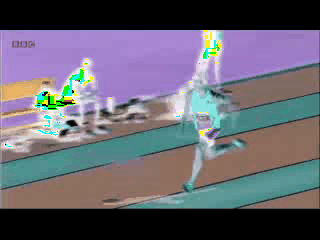

In [110]:
to_gif(video_data)

In [111]:
crop_size = 224
short_side_size = 256
transform_fn = video_transforms.Compose([video_transforms.Resize(short_side_size, interpolation='bilinear'),
                                         video_transforms.CenterCrop(size=(crop_size, crop_size)),
                                         volume_transforms.ClipToTensor(),
                                         video_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


clip_input = transform_fn(video_data)
print('Video data is downloaded and preprocessed.')

Video data is downloaded and preprocessed.


In [113]:
config_file = '/content/Video-based-Action-Recognition/model config/ircsn_v2_resnet152_f32s2_kinetics400.yaml'
cfg = get_cfg_defaults()
cfg.merge_from_file(config_file)
model = get_model(cfg)
model.eval()
print('%s model is successfully loaded.' % cfg.CONFIG.MODEL.NAME)

ircsn_v2_resnet152_f32s2_kinetics400 model is successfully loaded.


In [114]:
with torch.no_grad():
  probabilities = model(torch.unsqueeze(clip_input, dim=0)).numpy()
  print('The input video clip is classified to be class %d' % (np.argmax(probabilities)))
  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

The input video clip is classified to be class 279
Top 5 actions:


TypeError: ignored

In [ ]:
probabilities.shape

(1, 400)

In [100]:
config_file2 = '/content/Video-based-Action-Recognition/model config/i3d_resnet50_v1_kinetics400.yaml'
cfg2 = get_cfg_defaults()
cfg2.merge_from_file(config_file2)
model2 = get_model(cfg2)
model2.eval()
print('%s model is successfully loaded.' % cfg.CONFIG.MODEL.NAME)

100%|██████████| 109861/109861 [00:02<00:00, 37437.98KB/s]


ircsn_v2_resnet152_f32s2_kinetics400 model is successfully loaded.


In [112]:
with torch.no_grad():
  probabilities = model2(torch.unsqueeze(clip_input, dim=0)).numpy()
  print('The input video clip is classified to be class %d' % (np.argmax(probabilities)))
  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

The input video clip is classified to be class 367
Top 5 actions:


TypeError: ignored